# A4: Image Compression via Block-wise SVD

**Objective:** This notebook explores image compression using Singular Value Decomposition (SVD) applied block-wise to a grayscale image. We will compress an image by processing it in 8x8 blocks, applying SVD to each block, and reconstructing it using only the top 'k' singular values. We will analyze how the compression ratio and reconstruction error (image quality) change as 'k' varies from 1 to 8.

**Libraries Used:**
*   `cv2` (OpenCV): For loading and saving images.
*   `numpy`: For numerical operations, especially array manipulation and SVD.
*   `matplotlib.pyplot`: For displaying images and plotting graphs.
*   `os`: For creating directories to save output images.
*   `time` (Optional): For timing the compression process.


In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os 
import time 

In [1]:
pip install numpy matplotlib opencv-python Pillow



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: /Users/khushichoudhary/Documents/Projects/venv/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Image loaded successfully! Shape: (256, 256)


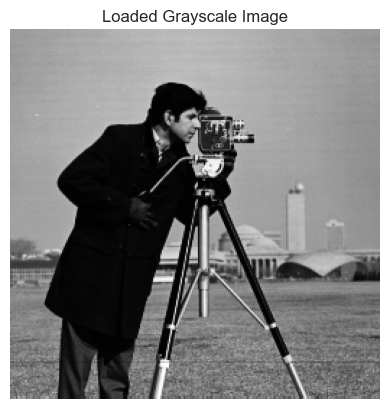

In [13]:
# --- Load the Image ---
image_path = '/Users/khushichoudhary/Documents/CSCI605/cameraman.png'
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if img is None:
    print(f"Error: Could not load image from {image_path}")
else:
    print(f"Image loaded successfully! Shape: {img.shape}")

    # Display the loaded image to verify
    plt.imshow(img, cmap='gray')
    plt.title("Loaded Grayscale Image")
    plt.axis('off') # Hide axes
    plt.show()

    # Convert to float for calculations 
    img_float = img.astype(np.float64)

## 1. Preprocessing

This section handles loading the image and preparing it for SVD processing.
1.  **Load Image:** The chosen image (`cameraman.png`) is loaded using OpenCV's `imread` function with the `IMREAD_GRAYSCALE` flag.
2.  **Check Dimensions:** We verify that the image height and width are divisible by 8, as required for non-overlapping 8x8 block processing. If not, the image would be cropped. (The 256x256 cameraman image meets this requirement).
3.  **Convert to Float:** The image data type is converted from `uint8` (0-255 integers) to `float64`. This is important because SVD calculations are numerical operations best performed on floating-point numbers.
4.  **Display Original:** The prepared image is displayed for verification.
5.  **Create Output Directory:** A directory is created to store the reconstructed images generated later.


Image loaded successfully! Original Shape: (256, 256)
Image dimensions are already divisible by 8.
Preprocessing complete. Image ready for block processing.
Final image shape for processing: (256, 256)


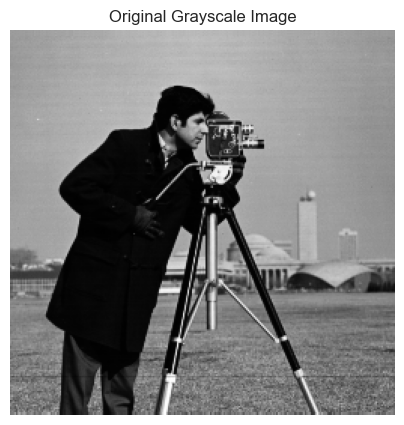

Output directory 'reconstructed_cameraman' ensured.


In [14]:
# Preprocessing - Load and Prepare Image
image_path = '/Users/khushichoudhary/Documents/CSCI605/cameraman.png'
output_dir = 'reconstructed_cameraman'

# Load the image in grayscale
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Check if loading was successful
if img is None:
    print(f"Error: Could not load image from {image_path}")
else:
    print(f"Image loaded successfully! Original Shape: {img.shape}")

    # Verify dimensions are divisible by 8
    height, width = img.shape
    if height % 8 != 0 or width % 8 != 0:
        print("Image dimensions are not divisible by 8. Cropping...")
        new_height = height - (height % 8)
        new_width = width - (width % 8)
        img = img[0:new_height, 0:new_width]
        print(f"Image cropped to shape: {img.shape}")
        height, width = img.shape 
    else:
        print("Image dimensions are already divisible by 8.")

    # Convert image to float64 for SVD calculations
    original_image_float = img.astype(np.float64)

    print("Preprocessing complete. Image ready for block processing.")
    print(f"Final image shape for processing: {original_image_float.shape}")

    # Display the original image
    plt.figure(figsize=(5, 5))
    plt.imshow(original_image_float, cmap='gray')
    plt.title("Original Grayscale Image")
    plt.axis('off')
    plt.show()

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"Output directory '{output_dir}' ensured.")


## 2. Block-wise SVD Function (`compress_block`)

This function implements the core SVD compression logic for a single 8x8 block.
1.  **Input:** Takes an 8x8 `block` (as a NumPy float array) and the number of singular values `k` to retain.
2.  **Apply SVD:** Computes the Singular Value Decomposition of the block: \( \text{block} = U \Sigma V^T \). `np.linalg.svd` returns the matrices U, the singular values s (as a 1D array), and Vh (\( V^T \)).
3.  **Truncate:** Selects the top `k` components:
    *   The first `k` columns of U (\( U_k \)).
    *   The first `k` singular values (\( s_k \)).
    *   The first `k` rows of Vh (\( V_k^T \)).
4.  **Reconstruct:** Rebuilds the block using only the selected components: \( \text{reconstructed\_block} = U_k \text{diag}(s_k) V_k^T \).
5.  **Return:** Returns the 8x8 reconstructed block.


In [15]:
# Define the SVD Compression Function
print("\n--- Defining SVD Compression Function ---")

def compress_block(block, k):
    """
    Applies SVD to an 8x8 block and reconstructs it using the top k singular values.

    Args:
        block (np.ndarray): An 8x8 numpy array (should be float type).
        k (int): The number of singular values to keep (1 <= k <= 8).

    Returns:
        np.ndarray: The reconstructed 8x8 block (float type).
    """
    # Basic validation (optional but good practice)
    if not (1 <= k <= 8):
        raise ValueError("k must be between 1 and 8 for an 8x8 block.")
    if block.shape != (8, 8):
         raise ValueError("Input block must be 8x8.")

    # Apply SVD
    # Using full_matrices=False is slightly more efficient here
    U, s, Vh = np.linalg.svd(block, full_matrices=False)

    # Keep only the top k components
    U_k = U[:, :k]
    s_k = s[:k]
    Vh_k = Vh[:k, :]

    # Reconstruct the block
    reconstructed_block = U_k @ np.diag(s_k) @ Vh_k

    return reconstructed_block

print("`compress_block` function defined.")



--- Defining SVD Compression Function ---
`compress_block` function defined.


## 3. Compression Analysis Loop

This section iterates through \( k = 1, ..., 8 \) to perform the compression and gather data.
For each value of `k`:
1.  **Initialize:** An empty array `reconstructed_image_k` is created to store the result for the current `k`.
2.  **Iterate Blocks:** The code loops through the original image in 8x8 non-overlapping blocks.
3.  **Compress/Reconstruct Block:** The `compress_block` function is called for each block with the current `k`.
4.  **Reassemble Image:** The reconstructed block is placed back into the `reconstructed_image_k` array.
5.  **Store Image:** The complete reconstructed image for `k` is stored.
6.  **Calculate Compression Ratio:** Computed as (Original data per block) / (Retained data per block) = \( 64 / (k \times (8+8+1)) = 64 / (17k) \).
7.  **Calculate Reconstruction Error:** The Frobenius norm of the difference between the original image and the reconstructed image (\( ||\text{Original} - \text{Reconstructed}_k||_F \)) is calculated. This measures the overall difference introduced by the compression.
8.  **Save Image:** The reconstructed image is saved as a PNG file after clipping values to [0, 255] and converting back to `uint8`.


In [6]:
# Compression Analysis Loop (Applying SVD and Calculating Metrics)
print("\n--- Starting Compression Analysis Loop (k=1 to 8) ---")

# Ensure the image variable is available from Cell 2
if 'original_image_float' not in locals():
     print("Error: Original image not processed. Please run Cell 2 first.")
     # Or re-run cell 2 logic here if needed
else:
    height, width = original_image_float.shape # Get dimensions again just in case
    k_values = list(range(1, 9)) # k = 1, 2, ..., 8
    compression_ratios = []
    reconstruction_errors = [] # Frobenius norm errors
    reconstructed_images = {} # Dictionary to store reconstructed images {k: image_array}
    processing_times = {} # Optional: track time per k

    # --- Loop over k ---
    for k in k_values:
        start_time = time.time() # Optional: start timer
        print(f"Processing for k = {k}...")
        # Create an empty array for the reconstructed image
        reconstructed_image_k = np.zeros_like(original_image_float)

        # Iterate through the image in non-overlapping 8x8 blocks
        for i in range(0, height, 8):
            for j in range(0, width, 8):
                block = original_image_float[i:i+8, j:j+8]
                reconstructed_block = compress_block(block, k)
                reconstructed_image_k[i:i+8, j:j+8] = reconstructed_block

        # Store the fully reconstructed image
        reconstructed_images[k] = reconstructed_image_k

        # Calculate Compression Ratio
        original_data_per_block = 64
        retained_data_per_block = k * (8 + 8 + 1) # 17*k
        ratio = original_data_per_block / retained_data_per_block
        compression_ratios.append(ratio)

        # Calculate Reconstruction Error (Frobenius Norm)
        error = np.linalg.norm(original_image_float - reconstructed_image_k, 'fro')
        reconstruction_errors.append(error)

        # Save the reconstructed image
        img_to_save = np.clip(reconstructed_image_k, 0, 255).astype(np.uint8)
        save_path = os.path.join(output_dir, f'cameraman_reconstructed_k{k}.png')
        cv2.imwrite(save_path, img_to_save)

        end_time = time.time() # Optional: end timer
        processing_times[k] = end_time - start_time # Optional: store time
        print(f"  -> Completed k={k}. Error: {error:.2f}, Ratio: {ratio:.4f}, Time: {processing_times[k]:.2f}s")


    print("\nCompression analysis complete.")



--- Starting Compression Analysis Loop (k=1 to 8) ---
Processing for k = 1...
  -> Completed k=1. Error: 3660.88, Ratio: 3.7647, Time: 0.05s
Processing for k = 2...
  -> Completed k=2. Error: 2067.93, Ratio: 1.8824, Time: 0.02s
Processing for k = 3...
  -> Completed k=3. Error: 1225.97, Ratio: 1.2549, Time: 0.02s
Processing for k = 4...
  -> Completed k=4. Error: 724.64, Ratio: 0.9412, Time: 0.02s
Processing for k = 5...
  -> Completed k=5. Error: 397.32, Ratio: 0.7529, Time: 0.02s
Processing for k = 6...
  -> Completed k=6. Error: 192.29, Ratio: 0.6275, Time: 0.02s
Processing for k = 7...
  -> Completed k=7. Error: 51.43, Ratio: 0.5378, Time: 0.02s
Processing for k = 8...
  -> Completed k=8. Error: 0.00, Ratio: 0.4706, Time: 0.02s

Compression analysis complete.


## 4. Analysis of Results

Here we analyze the relationship between `k`, compression ratio, reconstruction error, and visual quality based on the generated table, plots, and images.

**Compression Ratio:**
*   The "Compression Ratio vs. k" plot clearly shows that the compression ratio **decreases** as `k` increases.
*   This is expected because retaining more singular values (increasing `k`) means storing more data per block (\(17k\) values).
*   The highest compression ratio (\( \approx 3.76 \)) is achieved at \( k=1 \), storing only 17 values instead of 64 per block.
*   The lowest compression ratio (\( \approx 0.47 \)) occurs at \( k=8 \), where we store \( 17 \times 8 = 136 \) values, which is actually *more* than the original 64 values (due to storing U, s, and Vh components separately). This highlights that SVD is primarily for *lossy* compression by discarding information (\( k < 8 \)).

**Reconstruction Error:**
*   The "Reconstruction Error vs. k" plot shows that the Frobenius norm error **decreases rapidly** as `k` increases.
*   The largest drop in error occurs between \( k=1 \) and \( k=3 \), indicating that the first few singular values capture the most significant information/variance in the image blocks.
*   As more singular values are included (\( k=4 \) to \( k=7 \)), the error continues to decrease, but more slowly.
*   At \( k=8 \), the error drops to zero (or very close to it due to floating-point precision). This is because using all 8 singular values allows for a near-perfect reconstruction of the original 8x8 block.

**Visual Quality:**
*   The displayed image comparisons visually confirm the error measurements.
*   At \( k=1 \), the image is highly compressed but suffers from severe blockiness and loss of detail. Only the most dominant feature within each block is captured.
*   As `k` increases to 2 and 3, the image quality improves significantly, though block artifacts are still noticeable.
*   By \( k=4 \) or \( k=5 \), the image quality is quite good, and most major details are preserved.
*   At \( k=6 \) and \( k=8 \), the reconstructed images are visually very close, if not identical, to the original.

**Trade-off Summary:**
There is a clear trade-off between compression ratio and image quality.
*   **Low `k` (e.g., 1-3):** High compression, small file size, but significant quality loss and visible artifacts.
*   **High `k` (e.g., 5-8):** Low compression (larger file size, potentially even larger than original for k=8), but high image quality, very close to the original.
The optimal value of `k` depends on the specific application requirements – how much quality loss is acceptable versus how much file size reduction is needed. For this image, \( k=4 \) or \( k=5 \) might offer a reasonable balance.


In [7]:
# Display Results Summary
print("\n--- Results Summary ---")

# Check if results exist
if not compression_ratios or not reconstruction_errors:
    print("Analysis results not found. Please run Cell 4 first.")
else:
    print("\nResults Table:")
    print("k | Compression Ratio | Reconstruction Error (Frobenius) | Time (s)")
    print("-" * 65)
    for i in range(len(k_values)):
        k = k_values[i]
        # Optional: Include processing time if calculated
        time_str = f"{processing_times[k]:<8.2f}" if k in processing_times else "N/A"
        print(f"{k:<2}| {compression_ratios[i]:<18.4f}| {reconstruction_errors[i]:<30.4f}| {time_str}")




--- Results Summary ---

Results Table:
k | Compression Ratio | Reconstruction Error (Frobenius) | Time (s)
-----------------------------------------------------------------
1 | 3.7647            | 3660.8765                     | 0.05    
2 | 1.8824            | 2067.9262                     | 0.02    
3 | 1.2549            | 1225.9714                     | 0.02    
4 | 0.9412            | 724.6354                      | 0.02    
5 | 0.7529            | 397.3199                      | 0.02    
6 | 0.6275            | 192.2857                      | 0.02    
7 | 0.5378            | 51.4319                       | 0.02    
8 | 0.4706            | 0.0000                        | 0.02    



--- Generating Plots ---


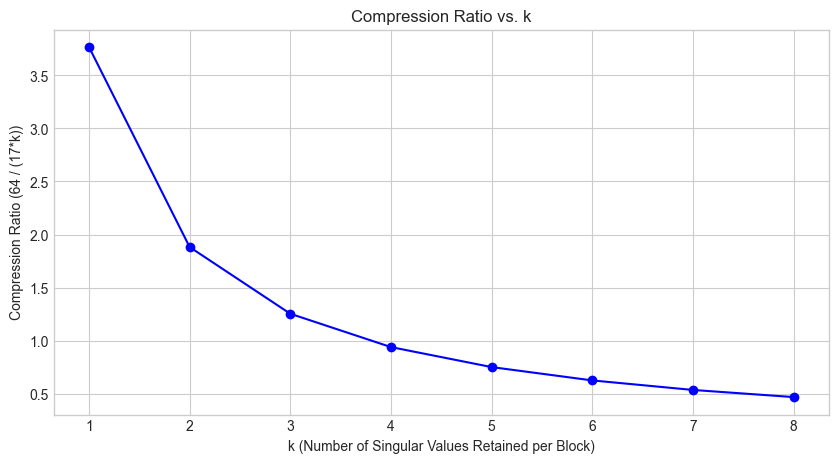

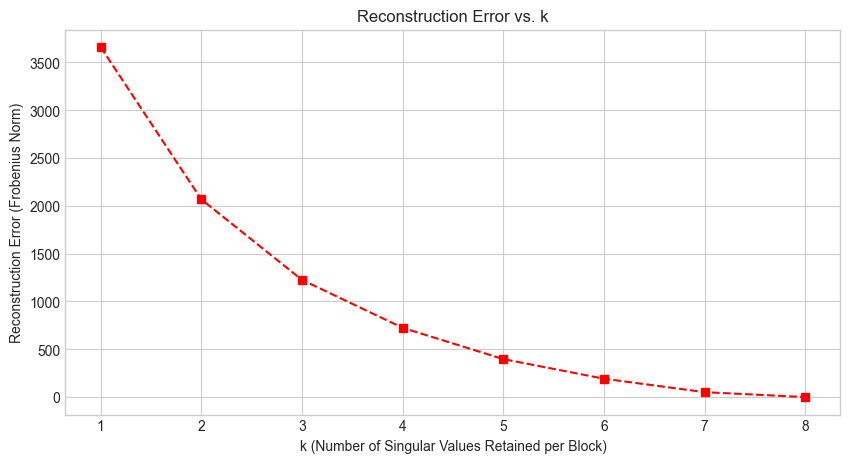

In [8]:
# Visualization - Plots
print("\n--- Generating Plots ---")

# Check if results exist
if not k_values or not compression_ratios or not reconstruction_errors:
     print("Analysis results not found. Please run Cell 4 first.")
else:
    # Plot Compression Ratio vs. k
    plt.figure(figsize=(10, 5))
    plt.plot(k_values, compression_ratios, marker='o', linestyle='-', color='b')
    plt.xlabel("k (Number of Singular Values Retained per Block)")
    plt.ylabel("Compression Ratio (64 / (17*k))")
    plt.title("Compression Ratio vs. k")
    plt.xticks(k_values)
    plt.grid(True)
    plt.show()

    # Plot Reconstruction Error vs. k
    plt.figure(figsize=(10, 5))
    plt.plot(k_values, reconstruction_errors, marker='s', linestyle='--', color='r')
    plt.xlabel("k (Number of Singular Values Retained per Block)")
    plt.ylabel("Reconstruction Error (Frobenius Norm)")
    plt.title("Reconstruction Error vs. k")
    plt.xticks(k_values)
    plt.grid(True)
    plt.show()



--- Displaying Image Comparison ---


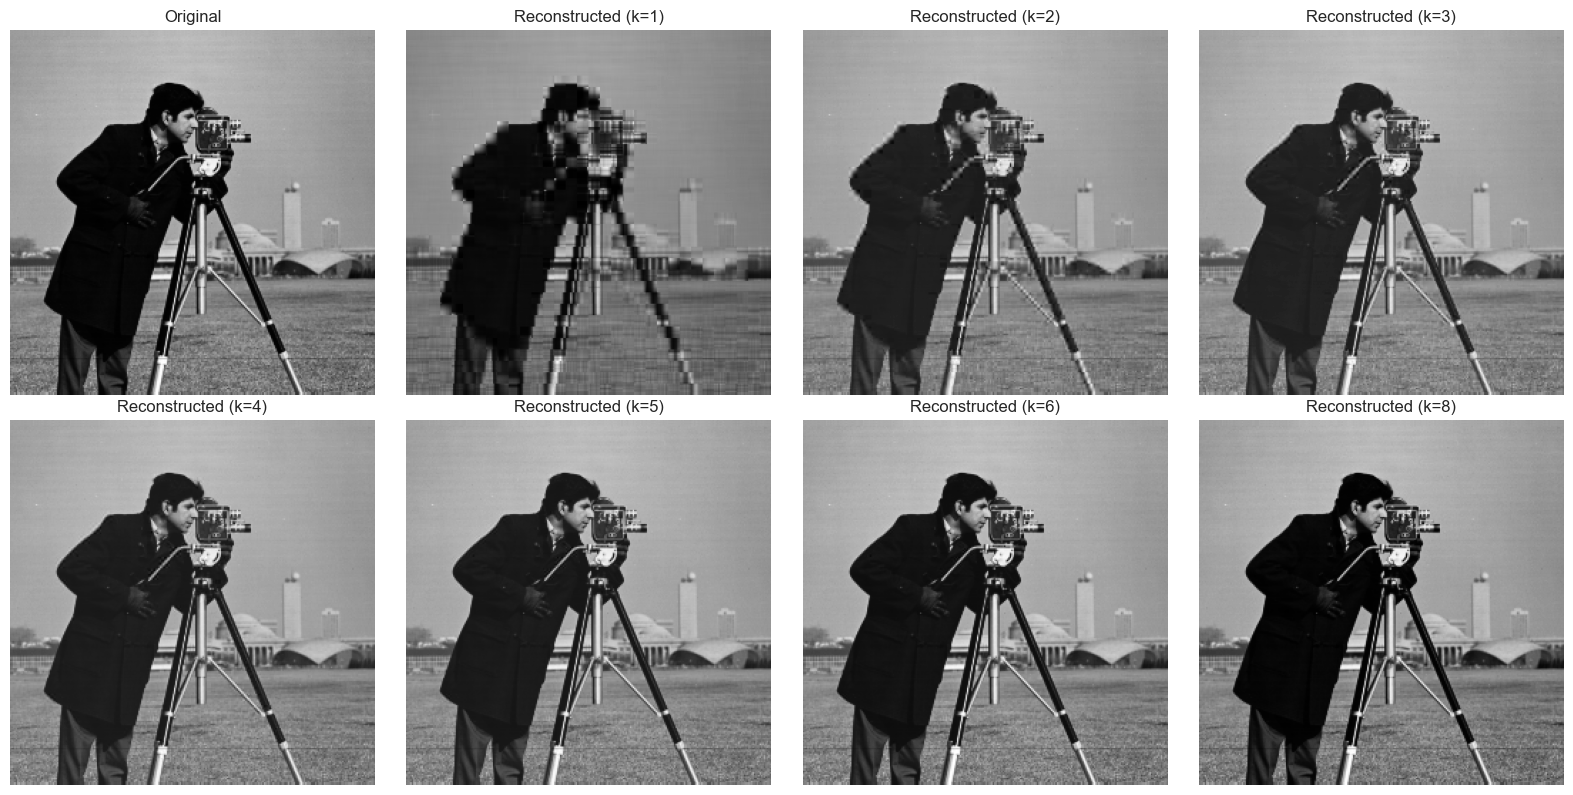

In [16]:
# Visualization - Image Comparison
print("\n--- Displaying Image Comparison ---")

if 'original_image_float' not in locals() or not reconstructed_images:
    print("Original or reconstructed images not found. Please run Cells 2 and 4.")
else:
    plt.figure(figsize=(16, 8)) 

    # Display Original Image
    plt.subplot(2, 4, 1)
    plt.imshow(original_image_float, cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Display Reconstructed Images for specific k values
    k_to_display = [1, 2, 3, 4, 5, 6, 8]
    plot_position = 2 
    for k_disp in k_to_display:
        if k_disp in reconstructed_images:
            plt.subplot(2, 4, plot_position)
            plt.imshow(reconstructed_images[k_disp], cmap='gray')
            plt.title(f"Reconstructed (k={k_disp})")
            plt.axis('off')
            plot_position += 1
        else:
            print(f"Warning: Reconstructed image for k={k_disp} not found.")

    plt.tight_layout() # Adjust layout
    plt.show()